In [2]:
import shutil, os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers, Sequential
from keras.applications.xception import Xception
from keras.models import load_model
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.densenet import DenseNet169
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from skimage.io import imread
from glob import glob

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
url = "input"

In [5]:
print(len(os.listdir("input/train")))

220025


In [107]:
df_data = pd.read_csv("input/train_labels.csv")

In [ ]:
print(df_data.shape)

In [ ]:
df_data.head()

In [ ]:
y = df_data["label"]
# podatke za učenje dijelimo na skup podataka za učenje i validation skup u omjeru 80:20
df_train, df_val = train_test_split(df_data, test_size=0.20, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

In [ ]:
df_train["label"].value_counts()

In [ ]:
df_val["label"].value_counts()

In [ ]:
base_dir = "base_dir"
os.mkdir(base_dir)

In [ ]:
# kreiramo strukturu direktorija
train_dir = os.path.join(base_dir, "train_dir")
os.mkdir(train_dir)

val_dir = os.path.join(base_dir, "val_dir")
os.mkdir(val_dir)

no_tumor_tissue = os.path.join(train_dir, "a_no_tumor_tissue")
os.mkdir(no_tumor_tissue)

has_tumor_tissue = os.path.join(train_dir, "b_has_tumor_tissue")
os.mkdir(has_tumor_tissue)

no_tumor_tissue = os.path.join(val_dir, "a_no_tumor_tissue")
os.mkdir(no_tumor_tissue)

has_tumor_tissue = os.path.join(val_dir, "b_has_tumor_tissue")
os.mkdir(has_tumor_tissue)

In [ ]:
df_data.set_index("id", inplace=True)

In [ ]:
# premještamo fotografije u nove direktorije
train_list = list(df_train["id"])
val_list = list(df_val["id"])

In [ ]:
for image in train_list:
    fname = image + ".tif"
    target = df_data.loc[image, "label"]
    
    if target == 0:
        label = "a_no_tumor_tissue"
    if target == 1:
        label = "b_has_tumor_tissue"
    
    src = os.path.join("input/train", fname)
    dst = os.path.join(train_dir, label, fname)
    shutil.copyfile(src, dst)

for image in val_list:
    fname = image + ".tif"
    target = df_data.loc[image,"label"]
    
    if target == 0:
        label = "a_no_tumor_tissue"
    if target == 1:
        label = "b_has_tumor_tissue"
    
    src = os.path.join("input/train", fname)
    dst = os.path.join(val_dir, label, fname)
    shutil.copyfile(src, dst)

In [2]:
# ImageDataGenerator za augmentation transformations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    channel_shift_range=0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

In [45]:
base_model = VGG19(include_top=False,
                  input_shape=(96,96,3),
                  weights="imagenet")

for layer in base_model.layers[:-15]:
    layer.trainable = False
    
for layer in base_model.layers:
    print(layer,layer.trainable)

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.summary()

<keras.engine.input_layer.InputLayer object at 0xb35e6c240> False
<keras.layers.convolutional.Conv2D object at 0xb35e6c390> False
<keras.layers.convolutional.Conv2D object at 0xb35e6ceb8> False
<keras.layers.pooling.MaxPooling2D object at 0xb35e8b240> False
<keras.layers.convolutional.Conv2D object at 0xb35e8b940> False
<keras.layers.convolutional.Conv2D object at 0xb36335400> False
<keras.layers.pooling.MaxPooling2D object at 0xb3634d940> False
<keras.layers.convolutional.Conv2D object at 0xb3634dac8> True
<keras.layers.convolutional.Conv2D object at 0xb364a4630> True
<keras.layers.convolutional.Conv2D object at 0xb365d3710> True
<keras.layers.convolutional.Conv2D object at 0xb365ede48> True
<keras.layers.pooling.MaxPooling2D object at 0xb367318d0> True
<keras.layers.convolutional.Conv2D object at 0xb36731630> True
<keras.layers.convolutional.Conv2D object at 0xb35022a58> True
<keras.layers.convolutional.Conv2D object at 0xb34ee8128> True
<keras.layers.convolutional.Conv2D object at 0

In [4]:
train_generator = train_datagen.flow_from_directory(
    "base_dir/train_dir",
    target_size=(96, 96),
    batch_size=10,
    class_mode="binary") # koristimo binary cross-entropy

validation_generator = test_datagen.flow_from_directory(
    "base_dir/val_dir",
    target_size=(96, 96),          
    batch_size=10,                                    
    class_mode="binary")

Found 176020 images belonging to 2 classes.
Found 44005 images belonging to 2 classes.


In [7]:
model.compile(loss="binary_crossentropy", optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=["acc"])

In [8]:
checkpoint = ModelCheckpoint(
    "./base.model",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min",
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode="auto"
)
reduce = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    verbose=1, 
    mode="auto",
    cooldown=1 
)

callbacks = [checkpoint, reduce]

In [9]:
history = model.fit_generator(train_generator, steps_per_epoch=2000, 
                    validation_data=validation_generator,
                    validation_steps=2000,
                    epochs=30, verbose=1, callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
2000/2000 [==============================] - 400s 200ms/step - loss: 0.4888 - acc: 0.7716 - val_loss: 0.3527 - val_acc: 0.8480

Epoch 00001: val_loss improved from inf to 0.35271, saving model to ./base.model
Epoch 2/30
2000/2000 [==============================] - 412s 206ms/step - loss: 0.3894 - acc: 0.8296 - val_loss: 0.3139 - val_acc: 0.8746

Epoch 00002: val_loss improved from 0.35271 to 0.31395, saving model to ./base.model
Epoch 3/30
2000/2000 [==============================] - 422s 211ms/step - loss: 0.3430 - acc: 0.8518 - val_loss: 0.2719 - val_acc: 0.8890

Epoch 00003: val_loss improved from 0.31395 to 0.27187, saving model to ./base.model
Epoch 4/30
2000/2000 [==============================] - 426s 213ms/step - loss: 0.3144 - acc: 0.8677 - val_loss: 0.2606 - val_acc: 0.8962

Epoch 00004: val_loss improved from 0.27187 to 0.26058, saving model to ./base.model
Epoch 5/30
2000/2000 [==============================] - 428s

In [10]:
model.save("model.h5")

In [17]:
import matplotlib.pyplot as plt

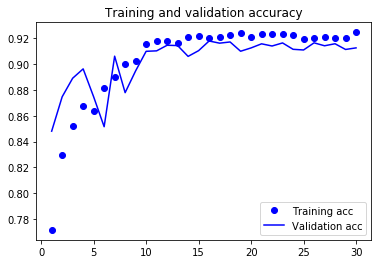

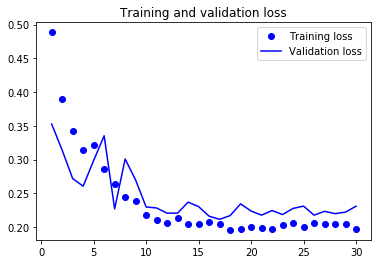

In [12]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

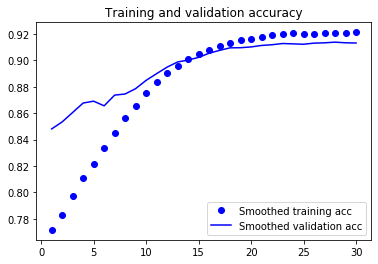

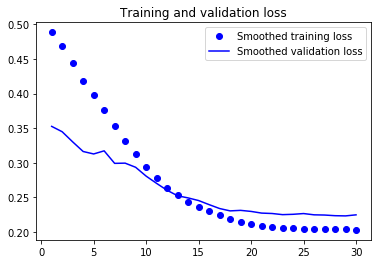

In [13]:
plt.plot(epochs, smooth_curve(acc), "bo", label="Smoothed training acc")
plt.plot(epochs, smooth_curve(val_acc), "b", label="Smoothed validation acc")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs,
smooth_curve(loss), "bo", label="Smoothed training loss")
plt.plot(epochs,
smooth_curve(val_loss), "b", label="Smoothed validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [5]:
from keras.models import load_model

new_model = load_model("model.h5")

In [9]:
roc_validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory("base_dir/val_dir",
                                                                                  target_size=(96,96),
                                                                                  batch_size=10,
                                                                                  class_mode='binary',
                                                                                  shuffle=False)
predictions = new_model.predict_generator(roc_validation_generator, steps=len(roc_validation_generator), verbose=1)

Found 22003 images belonging to 2 classes.
2201/2201 [==============================] - 1554s 706ms/step


In [10]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, fbeta_score

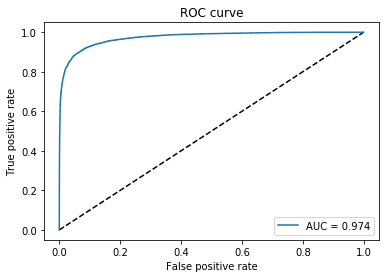

In [18]:
false_positive_rate, true_positive_rate, threshold = roc_curve(roc_validation_generator.classes, predictions)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(false_positive_rate, true_positive_rate, label="AUC = {:.3f}".format(area_under_curve))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend(loc="best")
plt.savefig("roc.png", bbox_inches="tight")
plt.show()

In [19]:
def y_pred(thres, y_prob):
    y_ret = y_prob.copy()
    y_ret[y_ret<thres] = 0
    y_ret[y_ret>=thres] = 1
    return y_ret

In [20]:
array1 = np.zeros(len(threshold))
for i in range(len(threshold)):
    array1[i]=fbeta_score(roc_validation_generator.classes, y_pred(threshold[i], predictions), 2, labels=None)

/Users/jloncar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
# Fbeta score
max(array1)

0.9202056421998533

In [22]:
cm = confusion_matrix(roc_validation_generator.classes, y_pred(threshold[np.argmax(array1)],predictions))


Confusion matrix

Example of confusion matrix usage to evaluate the quality
of the output of a classifier on the iris data set. The
diagonal elements represent the number of points for which
the predicted label is equal to the true label, while
off-diagonal elements are those that are mislabeled by the
classifier. The higher the diagonal values of the confusion
matrix the better, indicating many correct predictions.

The figures show the confusion matrix with and without
normalization by class support size (number of elements
in each class). This kind of normalization can be
interesting in case of class imbalance to have a more
visual interpretation of which class is being misclassified.

Here the results are not as good as they could be as our
choice for the regularization parameter C was not the best.
In real life applications this parameter is usually chosen
using :ref:`grid_search`.


Confusion matrix, without normalization
[[13  0  0]
 [ 0 10  6]
 [ 0  0  9]]
Normalized confusion

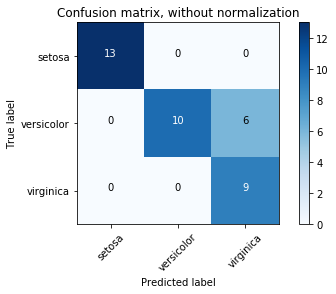

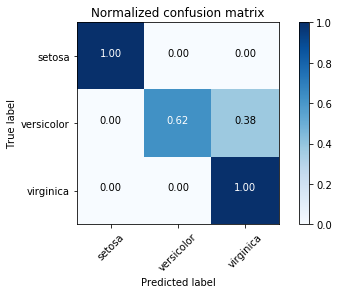

In [27]:
# %load plot_confusion_matrix.py
"""
================
Confusion matrix
================

Example of confusion matrix usage to evaluate the quality
of the output of a classifier on the iris data set. The
diagonal elements represent the number of points for which
the predicted label is equal to the true label, while
off-diagonal elements are those that are mislabeled by the
classifier. The higher the diagonal values of the confusion
matrix the better, indicating many correct predictions.

The figures show the confusion matrix with and without
normalization by class support size (number of elements
in each class). This kind of normalization can be
interesting in case of class imbalance to have a more
visual interpretation of which class is being misclassified.

Here the results are not as good as they could be as our
choice for the regularization parameter C was not the best.
In real life applications this parameter is usually chosen
using :ref:`grid_search`.

"""

print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


In [32]:
max_arg = np.argmax(array1)

Confusion matrix, without normalization
[[10965  2126]
 [  392  8520]]


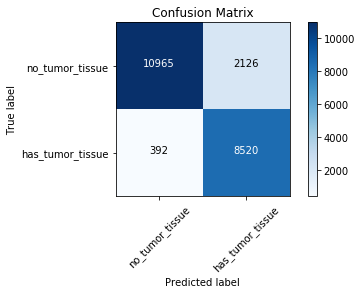

In [40]:
plot_confusion_matrix(cm, np.array(["no_tumor_tissue", "has_tumor_tissue"]), title="Confusion Matrix")

In [41]:
img_path = "input/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif"

In [126]:
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input

In [115]:
for layer in base_model.layers[:7]:
    # provjeravamo je li konvolucijski sloj
    if 'conv' not in layer.name:
        continue
    # filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)


In [118]:
filters, biases = base_model.layers[1].get_weights()

f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

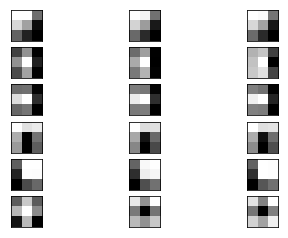

In [121]:
# prikazujemo prvih nekoliko filtera
n_filters, ix = 6, 1
for i in range(n_filters):
    f = filters[:, :, :, i]
    # svaki kanal prikazujemo zasebno
    for j in range(3):
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # prikazujemo kanal filtera u sivim tonovima
        plt.imshow(f[:, :, j], cmap="gray")
        ix += 1
plt.show()

In [124]:
base_model = models.Model(inputs=base_model.inputs, outputs=base_model.layers[1].output)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


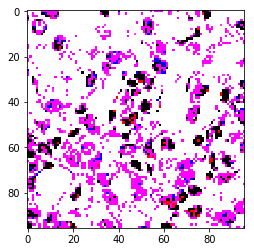

In [139]:
img = image.load_img(img_path, target_size=(96, 96))
# konvertiramo sliku u polje
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)
plt.imshow(img_tensor[0])
plt.show()

In [142]:
feature_maps = base_model.predict(img)

In [143]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
Total params: 1,792
Trainable params: 0
Non-trainable params: 1,792
_________________________________________________________________


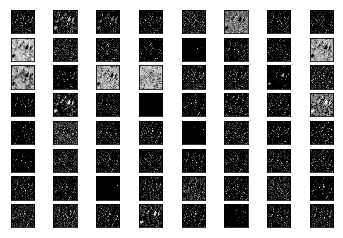

In [144]:
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[0, :, :, ix-1], cmap="gray")
        ix += 1
plt.show()

In [148]:
base_model = VGG19(include_top=False,
                  input_shape=(96,96,3),
                  weights="imagenet")

In [151]:
ixs = [2, 4, 5]
base_model.layers[5]

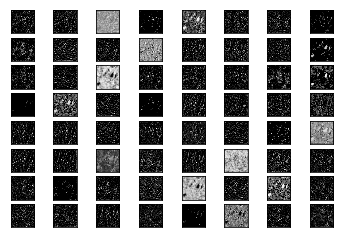

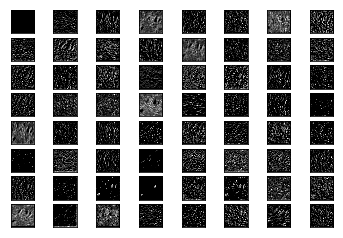

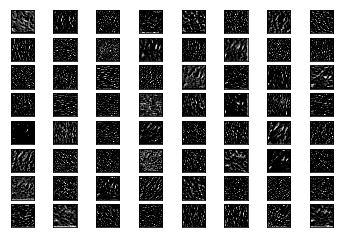

In [152]:
outputs = [base_model.layers[i].output for i in ixs]
base_model = models.Model(inputs=base_model.inputs, outputs=outputs)

feature_maps = base_model.predict(img)

square = 8
for fmap in feature_maps:
    ix = 1
    for _ in range(square):
        for _ in range(square):
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(fmap[0, :, :, ix-1], cmap="gray")
            ix += 1
    plt.show()

In [7]:
test_dir = "input/test"
test_files = glob(os.path.join(test_dir, "*.tif"))
kaggle_submission = pd.DataFrame()
batch_size = 5000
max_index = len(test_files)
for index in range(0, max_index, batch_size):
    print("Indeksi: %i - %i"%(index, index + batch_size))
    test_df = pd.DataFrame({"path": test_files[index:index+batch_size]})
    test_df["id"] = test_df.path.map(lambda x: x.split("/")[2].split(".")[0])
    test_df["image"] = test_df["path"].map(imread)
    k_test = np.stack(test_df["image"].values)
    k_test = (k_test - k_test.mean()) / k_test.std()
    predictions = new_model.predict(k_test)
    test_df["label"] = predictions
    kaggle_submission = pd.concat([kaggle_submission, test_df[["id", "label"]]])
kaggle_submission.head()

Indexes: 0 - 5000
Indexes: 5000 - 10000
Indexes: 10000 - 15000
Indexes: 15000 - 20000
Indexes: 20000 - 25000
Indexes: 25000 - 30000
Indexes: 30000 - 35000
Indexes: 35000 - 40000
Indexes: 40000 - 45000
Indexes: 45000 - 50000
Indexes: 50000 - 55000
Indexes: 55000 - 60000


,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,0.254868
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,0.897855
2,19709bec800f372d0b1d085da6933dd3ef108846,0.007623
3,7a34fc34523063f13f0617f7518a0330f6187bd3,0.005154
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0.004098


In [8]:
kaggle_submission.to_csv("kaggle_submision.csv", index=False, header=True)